In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u


In [2]:
no_jolly = fits.open("flint_nojolly/archive_copies_proc/47138/SB47138.EMU_1141-55.round2.i.contsub.time.linmos.cube.fits", memmap=True)
no_jolly_data = no_jolly[0].data

print(no_jolly_data.shape)


(3618, 5184, 5990)


In [3]:
from dataclasses import dataclass

@dataclass(frozen=True)
class Result:
    mean: np.ndarray
    std: np.ndarray

def get_mean_spec(path):
    no_jolly = fits.open(path, memmap=True)
    no_jolly_data = np.squeeze(no_jolly[0].data)
    print(f"{no_jolly_data.shape=}")
    _mean = np.nanmean(no_jolly_data[:, 2500:2750, 2500:2750], axis=(1,2))
    print(f"{_mean.shape=}")
    _std = np.nanstd(no_jolly_data[:, 2500:2750, 2500:2750], axis=(1,2))
    print(f"{_std.shape=}")

    return Result(mean=_mean, std=_std)


no_jolly_spec = get_mean_spec("flint_nojolly/archive_copies_proc/47138/SB47138.EMU_1141-55.round2.i.contsub.time.linmos.cube.fits")
print(f"Got {no_jolly_spec.mean.shape=}")

with_jolly_spec = get_mean_spec("flint_wjolly/archive_copies_proc/47138/SB47138.EMU_1141-55.round2.i.contsub.time.linmos.cube.fits")
print(f"Got {with_jolly_spec.mean.shape=}")


no_jolly_data.shape=(3618, 5184, 5990)


/tmp/ipykernel_5477/398234891.py:12: RuntimeWarning: Mean of empty slice
  _mean = np.nanmean(no_jolly_data[:, 2500:2750, 2500:2750], axis=(1,2))


_mean.shape=(3618,)


/datasets/work/jones-storage/work/miniconda/miniforge3/envs/flint_main/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


_std.shape=(3618,)
Got no_jolly_spec.mean.shape=(3618,)
no_jolly_data.shape=(3618, 5184, 5990)
_mean.shape=(3618,)
_std.shape=(3618,)
Got with_jolly_spec.mean.shape=(3618,)


[Text(0.5, 0, 'Timestep (10s)'),
 Text(0, 0.5, '(no - with)/with'),
 Text(0.5, 1.0, 'Fractional Difference of mean'),
 (-100.0, 100.0)]

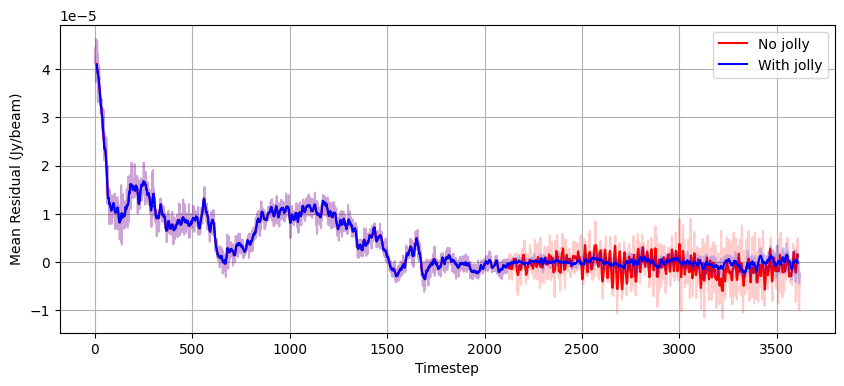

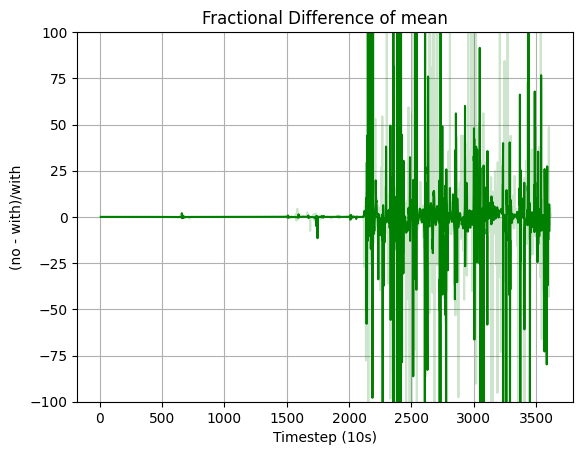

In [6]:
from scipy.signal import savgol_filter

frac_diff = (no_jolly_spec.mean - with_jolly_spec.mean) / with_jolly_spec.mean

window_size = 20

smoothed_no_spec = savgol_filter(no_jolly_spec.mean, 20, 2)
smoothed_with_spec = savgol_filter(with_jolly_spec.mean, 20, 2)

smoothed_frac_diff = (smoothed_no_spec - smoothed_with_spec) / smoothed_with_spec 



fig, ax = plt.subplots(1,1, figsize=(10, 4))

ax.plot(
    no_jolly_spec.mean,
    color="red",
    alpha=0.2,
)
ax.plot(
    smoothed_no_spec,
    label="No jolly",
    color="red",
)

ax.plot(
    with_jolly_spec.mean,
    color="blue",
    alpha=0.2,
)
ax.plot(
    smoothed_with_spec,
    color="blue",
    label="With jolly",    
)


ax.grid()
ax.set(
    xlabel="Timestep",
    ylabel="Mean Residual (Jy/beam)"
)
ax.legend()

fig, ax = plt.subplots(1,1)

ax.plot(
    frac_diff,
    color="green",
    alpha=0.2
)

ax.plot(
    smoothed_frac_diff,
    color="green"
)

ax.grid()
ax.set(
    xlabel="Timestep (10s)",
    ylabel="(no - with)/with",
    title="Fractional Difference of mean",
    ylim=(-100, 100)
)



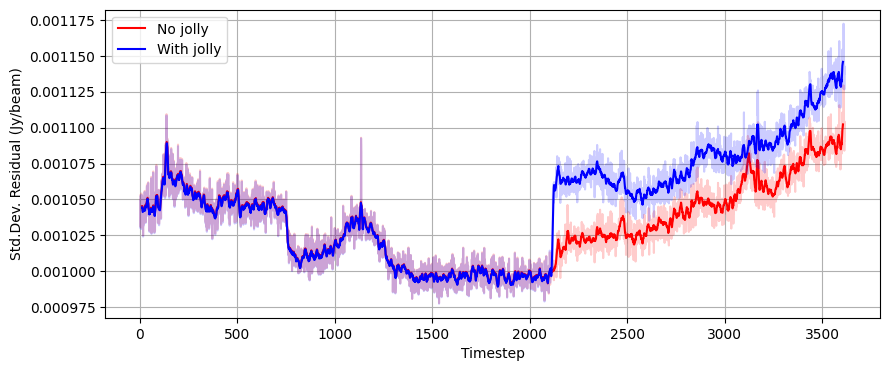

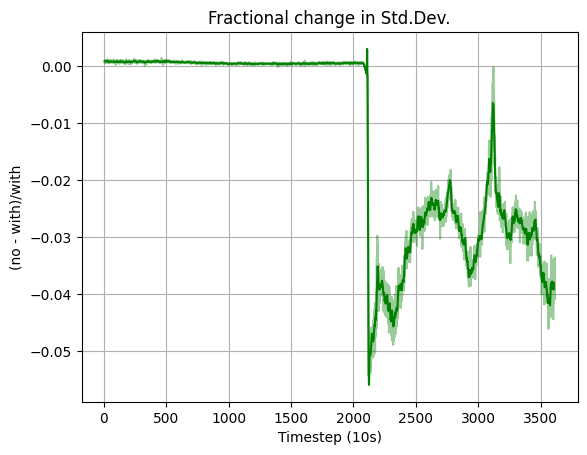

In [7]:


frac_diff = (no_jolly_spec.std - with_jolly_spec.std) / with_jolly_spec.std

window_size = 20

smoothed_no_spec = savgol_filter(no_jolly_spec.std, 20, 2)
smoothed_with_spec = savgol_filter(with_jolly_spec.std, 20, 2)

smoothed_frac_diff = (smoothed_no_spec - smoothed_with_spec) / smoothed_with_spec 


fig, ax = plt.subplots(1,1, figsize=(10, 4))

ax.plot(
    no_jolly_spec.std,
    color="red",
    alpha=0.2,
)
ax.plot(
    smoothed_no_spec,
    color="red",
    label="No jolly",
    
)

ax.plot(
    with_jolly_spec.std,
    color="blue",
    alpha=0.2,
)

ax.plot(
    smoothed_with_spec,
    color="blue",
    label="With jolly",
)


ax.grid()
ax.set(
    xlabel="Timestep",
    ylabel="Std.Dev. Residual (Jy/beam)"
)
ax.legend()

fig, ax = plt.subplots(1,1)

ax.plot(
    frac_diff,
    alpha=0.4,
    color="green"
)
ax.plot(
    smoothed_frac_diff,
    color="green"
)
ax.set(
    xlabel="Timestep (10s)",
    ylabel="(no - with)/with",
    title="Fractional change in Std.Dev."
)

ax.grid()



In [8]:
from astropy.coordinates import search_around_sky

no_cat = Table.read("flint_nojolly/archive_copies/47138/SB47138.EMU_1141-55.round2.i.optimal.linmos_comp.fits")
w_cat = Table.read("flint_wjolly/archive_copies/47138/SB47138.EMU_1141-55.round2.i.optimal.linmos_comp.fits")

print(f"{len(no_cat)=}")
print(f"{len(w_cat)=}")


no_sources = SkyCoord(no_cat["ra"] * u.deg, no_cat["dec"] * u.deg)
w_sources = SkyCoord(w_cat["ra"] * u.deg, w_cat["dec"] * u.deg)

print(f"Matching ...")
matches = search_around_sky(no_sources, w_sources, 5*u.arcsec)

print(f"{len(matches[0])=}")



len(no_cat)=37528
len(w_cat)=36912
Matching ...
len(matches[0])=36374


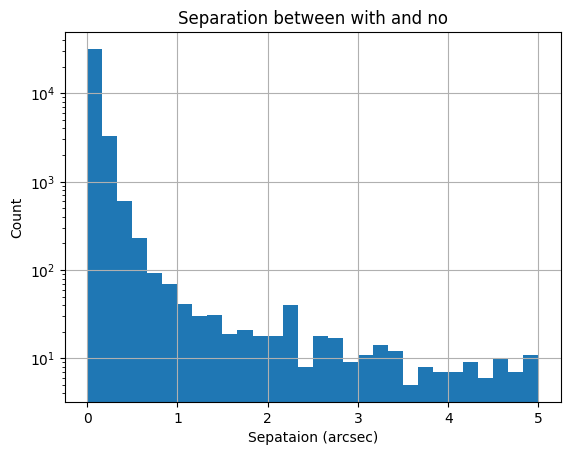

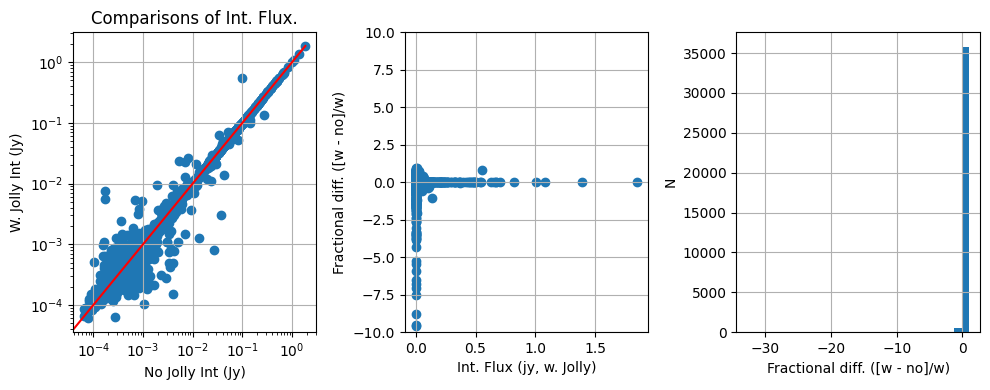

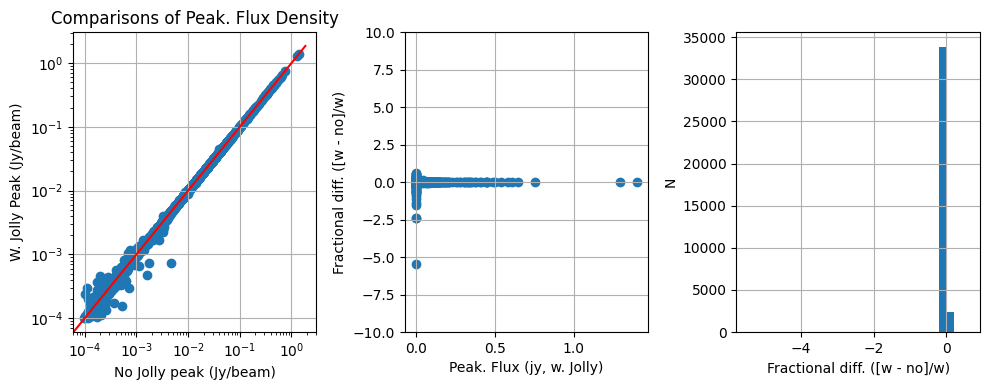

In [20]:
fig, ax = plt.subplots(1,1)

ax.hist(
    matches[2]*3600,
    bins=30,
)

ax.grid()
ax.set(
    xlabel="Sepataion (arcsec)", 
    ylabel="Count",
    yscale="log",
    title="Separation between with and no"
)

d_max = np.nanmax(
    [
        np.nanmax(no_cat["int_flux"]),
        np.nanmax(w_cat["int_flux"]),
    ]
)

x = np.linspace(0, d_max, 100)

no_cat_int = no_cat["int_flux"][matches[0]]
w_cat_int = w_cat["int_flux"][matches[1]]
frac_cat_int = (w_cat_int - no_cat_int) / w_cat_int

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 4))
ax.scatter(
    no_cat_int,
    w_cat_int,
)
ax.plot(
    x, x, color="red"
)
ax.loglog()
ax.grid()
ax.set(
    xlabel="No Jolly Int (Jy)",
    ylabel="W. Jolly Int (Jy)",
    title="Comparisons of Int. Flux."
)

ax1.scatter(
    w_cat_int,
    frac_cat_int,
)
ax1.grid()

ax1.set(
    xlabel="Int. Flux (jy, w. Jolly)",
    ylabel="Fractional diff. ([w - no]/w)",
    ylim=[-10, 10]
)

ax2.hist(
    frac_cat_int,
    bins=30
)
ax2.grid()
ax2.set(
    xlabel="Fractional diff. ([w - no]/w)",
    ylabel="N"
)


no_cat_peak = no_cat["peak_flux"][matches[0]]
w_cat_peak = w_cat["peak_flux"][matches[1]]
frac_diff_peak = (w_cat_peak - no_cat_peak) / w_cat_peak

fig.tight_layout()

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 4))

ax.scatter(
    no_cat_peak,
    w_cat_peak,
)
ax.plot(
    x, x, color="red"
)
ax.loglog()
ax.grid()
ax.set(
    xlabel="No Jolly peak (Jy/beam)",
    ylabel="W. Jolly Peak (Jy/beam)",
    title="Comparisons of Peak. Flux Density"
)

ax1.scatter(
    w_cat_peak,
    frac_diff_peak
)
ax1.grid()

ax1.set(
    xlabel="Peak. Flux (jy, w. Jolly)",
    ylabel="Fractional diff. ([w - no]/w)",
    ylim=[-10, 10]
)


ax2.hist(
    frac_diff_peak,
    bins=30
)
ax2.grid()
ax2.set(
    xlabel="Fractional diff. ([w - no]/w)",
    ylabel="N"
)

fig.tight_layout()



In [ ]:
def get_mean_spec(path):
    no_jolly = fits.open(path, memmap=True)
    no_jolly_data = np.squeeze(no_jolly[0].data)
    print(no_jolly_data.shape)
    # 4739 2407
    _mean = np.nanmean(no_jolly_data[:, 5000:6000, 5000:6000], axis=(1,2))
    _std = np.nanstd(no_jolly_data[:, 5000:6000, 5000:6000], axis=(1,2))

    return Result(mean=_mean, std=_std)



no_jolly_spec = get_mean_spec("flint_nojolly/archive_copies_proc/47138/SB47138.EMU_1141-55.round2.i.contsub.freq.linmos.cube.fits")
print(f"Got {no_jolly_spec.mean.shape=}")

with_jolly_spec = get_mean_spec("flint_wjolly/archive_copies_proc/47138/SB47138.EMU_1141-55.round2.i.contsub.freq.linmos.cube.fits")
print(f"Got {with_jolly_spec.mean.shape=}")

(288, 5382, 6143)


/tmp/ipykernel_5477/897210614.py:6: RuntimeWarning: Mean of empty slice
  _mean = np.nanmean(no_jolly_data[:, 5000:6000, 5000:6000], axis=(1,2))


Got no_jolly_spec.mean.shape=(288,)
(288, 5382, 6143)
Got with_jolly_spec.mean.shape=(288,)


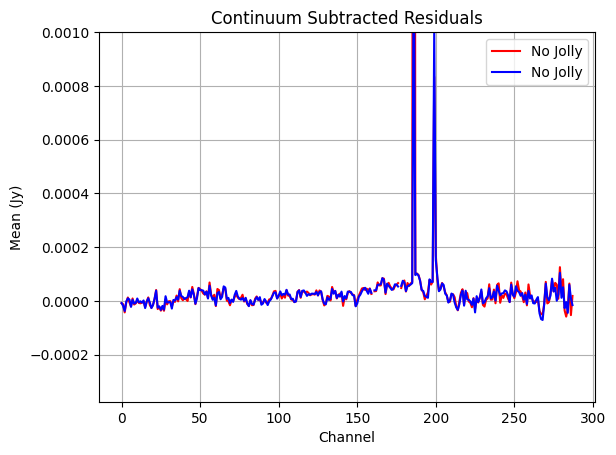

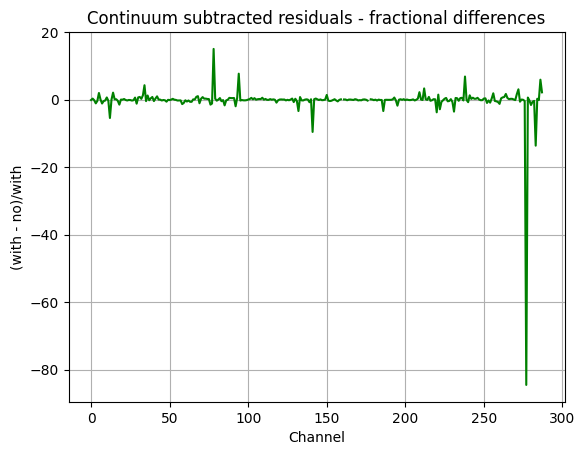

In [5]:
fig, ax = plt.subplots(1,1)

ax.plot(
    no_jolly_spec.mean,
    label="No Jolly",
    color="red",
)
ax.plot(
    with_jolly_spec.mean,
    label="No Jolly",
    color="blue"
)
ax.legend()
ax.set(
    ylim=[None, 0.001],
    xlabel="Channel",
    ylabel="Mean (Jy)",
    title="Continuum Subtracted Residuals"
)
ax.grid()

diff_spec = (with_jolly_spec.mean - no_jolly_spec.mean) / with_jolly_spec.mean

fig, ax = plt.subplots(1,1)

ax.plot(
    diff_spec,
    color="green"
)

ax.set(
    xlabel="Channel",
    ylabel="(with - no)/with",
    title="Continuum subtracted residuals - fractional differences"
)

ax.grid()



d.shape=(1, 288, 20, 20)
d.shape=(1, 288, 20, 20)


[Text(0.5, 0, 'Channel Index'),
 Text(0, 0.5, 'Fractions Residual peak Flux Difference (Jy/beam, (w-no)/w )')]

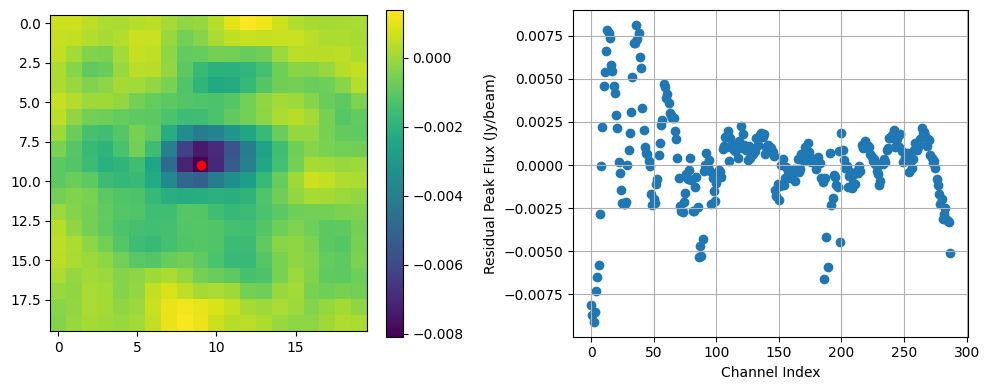

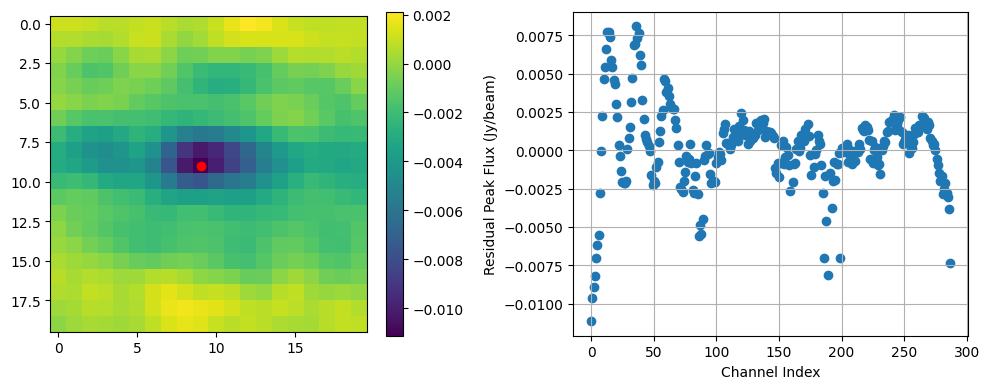

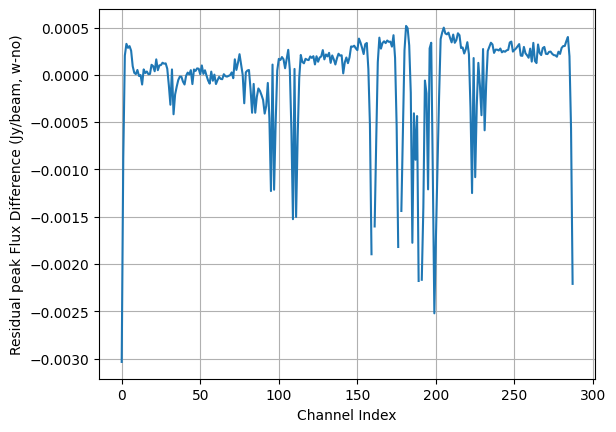

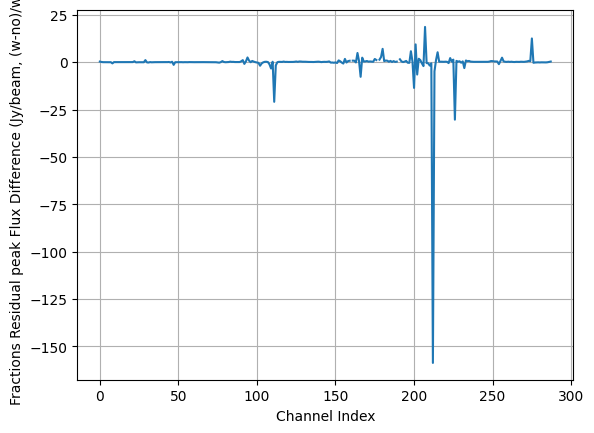

In [29]:
from pathlib import Path

@dataclass
class Source:
    data: np.ndarray
    min_d: tuple[int, int]
    file_path: str | Path 
    pos: tuple[int, int]
    spectrum: np.ndarray

def get_slices(pos_xy: tuple[int,int], size=20):
    d = size // 2
    return (
        slice(pos_xy[0]-d, pos_xy[0]+d),
        slice(pos_xy[1]-d, pos_xy[1]+d),
    )

def get_source_data(file_path):
    with fits.open(file_path, memmap=True) as f:
        pos_xy = (2407,4739)
        slices = get_slices(pos_xy=pos_xy)
        d = f[0].data[..., slices[0], slices[1]]
        
        print(f"{d.shape=}")

    min_d = np.argmin(d[0,0])
    min_d = np.unravel_index(min_d, d[0,0].shape)
    spectrum = d[0,:,min_d[1], min_d[0]]

    fig, (ax, ax1) = plt.subplots(1,2, figsize=(10, 4))

    cim = ax.imshow(
        np.squeeze(d)[0]
    )
    ax.scatter(*min_d, color="red")

    fig.colorbar(cim)
    
    ax1.scatter(
        np.arange(d.shape[1]),
        spectrum
    )
    ax1.grid()
    ax1.set(
        xlabel="Channel Index",
        ylabel="Residual Peak Flux (Jy/beam)"
    )
    fig.tight_layout()
    
    return Source(
        data=d,
        min_d=min_d,
        pos=pos_xy,
        file_path=file_path,
        spectrum=spectrum
    )
    
no_s1 = get_source_data("flint_nojolly/archive_copies_proc/47138/SB47138.EMU_1141-55.round2.i.contsub.freq.linmos.cube.fits")
w_s1 = get_source_data("flint_wjolly/archive_copies_proc/47138/SB47138.EMU_1141-55.round2.i.contsub.freq.linmos.cube.fits")


fig, ax = plt.subplots(1,1)

ax.plot(
    w_s1.spectrum - no_s1.spectrum
)
ax.grid()
ax.set(
    xlabel="Channel Index",
    ylabel="Residual peak Flux Difference (Jy/beam, w-no)"
)


fig, ax = plt.subplots(1,1)

ax.plot(
    (w_s1.spectrum - no_s1.spectrum)/w_s1.spectrum
)
ax.grid()
ax.set(
    xlabel="Channel Index",
    ylabel="Fractions Residual peak Flux Difference (Jy/beam, (w-no)/w )"
)


